# GEOS 518: Applied Hydrologic Modeling
## Problem Set 2: Autoregressive Models
## Cameron Carsley

In this Juypter Notebook I will complete the following tasks with the discharges 
from the Yellowstone River near Livingston, MT for water years 2007-2017

1. Read in the dataset and perform any additional pre-processing needed

2. Split the dataset into a "training" dataset used to estimate the parameters
 of the AR model, and a "test" dataset against which I will test the model.
3. Estimate the parameters of an AR(1) model using the training dataset
    * Compute the  autocorrelation function
    * Use the Yule-Walker equations to estimate the AR(1) parameters
    * Use the statsmodel AR tools to estimate the parameters based on the 
    dataset.
    * Compare the YW parameters to those from the statsmodel library
4. Estimate the parameters of an AR(2) model using the training dataset
    * Compute the  autocorrelation function
    * Use the Yule-Walker equations to estimate the AR(1) parameters
    * Use the statsmodel AR tools to estimate the parameters based on the 
    dataset.
    * Compare the YW parameters to those from the statsmodel library
5. Apply the AR(1) and AR(2) models to the "test" dataset (the one witheld from
 parameter estimation)
6. Plot the modeled time series for the AR(1) and AR(2) models against the observed
 time series for comparison
7. Comment on key differences and distinctions between the models themselves and the
 extent to which they reproduce the observations.


### 1. Read in the dataset and perform any additional pre-processing needed (compute water years)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as sm
from pandas.core import datetools

# Load the Yellowstone River's discharge dataset
#df = pd.read_pickle('..\H:\Hydrologic_Modeling\YellowstoneRiverQ_2007-2017.pkl')
df = pd.read_pickle('YellowstoneRiverQ_2007-2017.pkl')

# Create a Water Year column for our pandas data frame. This is a pretty 
# simple thing to do, but may not be necessary if you're not dealing with
# discharge data. Here's how it goes:
# 1. Create an empty array that is full of zeros and equal in length to 
#    the number of days in the record
WY = np.zeros(len(df['Y'].index)) 

# 2. For those records where the month is less than 10, their associated 
#    year is the correct water year
WY[df['M'].values < 10] = df['Y'].values[df['M'].values < 10] 

# 3. For those records where the month is greater than or equal to 10, 
#    the correct water year is one more than the current calendar year
WY[df['M'].values >= 10] = df['Y'].values[df['M'].values >= 10] + 1

# 4. Save the water year array as a column in the pandas data frame, as an
#    integer
df['WY'] = WY.astype(int)

# Print the first and last 10 records just to make sure we loaded the data okay
qrows = np.concatenate([np.arange(0,10,1),np.arange(-11,-1,1)])
df.iloc[qrows,:]

,Y,M,D,Q,SerDates,WY
0,2007,10,1,34.264634,2007-10-01,2008
1,2007,10,2,34.547813,2007-10-02,2008
2,2007,10,3,35.397350,2007-10-03,2008
3,2007,10,4,36.813243,2007-10-04,2008
4,2007,10,5,39.361853,2007-10-05,2008
5,2007,10,6,42.476819,2007-10-06,2008
6,2007,10,7,45.308607,2007-10-07,2008
7,2007,10,8,41.910462,2007-10-08,2008
8,2007,10,9,40.777747,2007-10-09,2008
9,2007,10,10,40.777747,2007-10-10,2008


### 2. Split the dataset into a "training" dataset used to estimate the parameters of the AR model, and a "test" dataset against which I will test the model.

In [4]:
# In the following example, I segment the whole dataframe
# into a training dataset (everything that's not Water Year 2017) and
# a test dataset (everything that is Water Year 2017).
df_train = df[df.WY != 2017]  # != means does not equal
df_test  = df[df.WY == 2017]  # == means equals

## 3. Estimate the parameters of an AR(1) model using the training dataset

### Compute the autocorrelation function

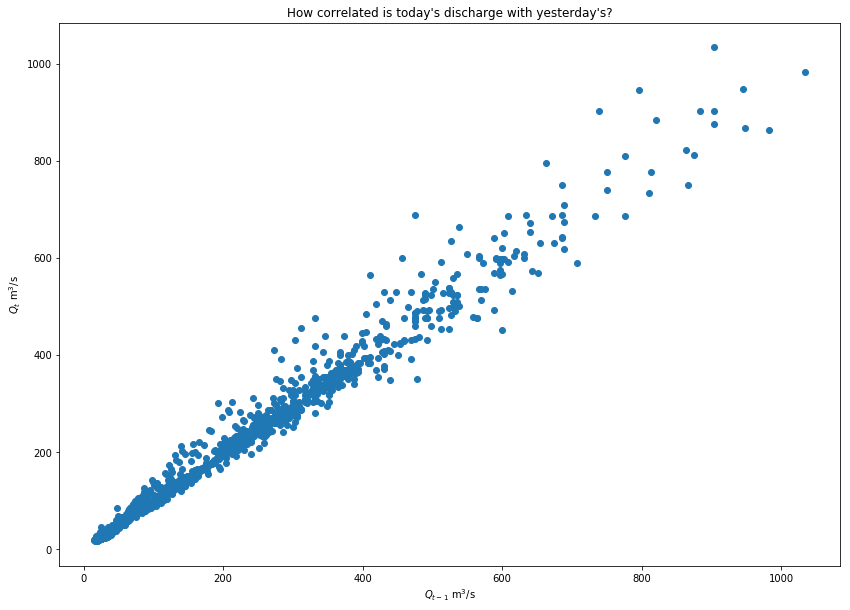

R value of today vs. 1 days ago: 0.992210640748


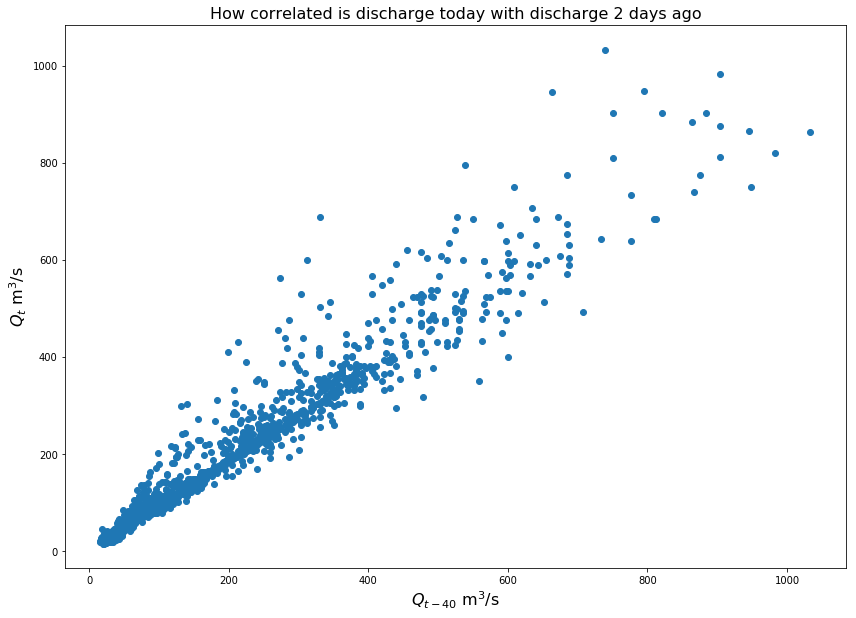

R^2 value of today vs. 2 days ago: 0.976463037808


In [29]:
# AC with 1 day lag:

# Use the pandas .values operator to load the values of discharge (the 'Q' column)
# from the pandas dataframe into a numpy array
Q = df_train['Q'].values 

# Use numpy array indexing to get discharge from October 2, 2000 to September 30, 2015. 
# The 'end' of a numpy array can be indexed using -1: as if the index in the negative direction
# wraps back around to the end of the record.  Array is N-1 in length.
Qt   = Q[1:-1]   # make array of (t+1 to t-1)

# Similarly get discharge from October 1, 2000 to September 29, 2015 by getting data from the 
# beginning of the record to the 'end' minus 1 using the -2 as the index. Array is N-1 in length.
Qtm1 = Q[0:-2]   # make array of (t to t-2 )

# Use Matplotlib to create a scatter plot of these two time series, create a title and label axes
plt.figure(figsize=(14,10))  # make figure large enough to view easily
plt.plot(Qtm1,Qt,'o')       # plot (t+1 to t-1) vs (t to t-2)
plt.title('How correlated is today\'s discharge with yesterday\'s?')
plt.xlabel('$Q_{t-1}$ m$^3$/s')
plt.ylabel('$Q_t$ m$^3$/s')
plt.show()

R1 = np.corrcoef(Qt, Qtm1)
print('R value of today vs. 1 days ago:', R1[0,1])

# AC with 2 days lag

Qt   = Q[2:-1] # start 2 days from now
Qtmk = Q[0:-(3)] # today

# Use Matplotlib to create a scatter plot of these two time series, create a title and label axes
plt.figure(figsize=(14,10))
plt.plot(Qtmk,Qt,'o')
plt.title('How correlated is discharge today with discharge 2 days ago',fontsize=16)
plt.xlabel('$Q_{t-40}$ m$^3$/s',fontsize=16)
plt.ylabel('$Q_t$ m$^3$/s',fontsize=16)
plt.show()

R2 = np.corrcoef(Qt, Qtmk)
print('R^2 value of today vs. 2 days ago:', R2[0,1])

### Use the Yule-Walker equations to estimate the AR(1) parameters

In [28]:
# phi(1) = rho(1) = R1

AR1_PHI1 = R1[0,1]   # Phi1 for AR(1) equals AR1 autocorrelation coeff.
print('phi1 = ', AR1_PHI1)

AR1_a = np.mean(Q)   # a1 equals the mean of the data
print('a1 =', AR1_a)

print('Zhat(1) =', AR1_PHI1,'*Ztm1 +', AR1_a )

phi1 =  0.992042229719
a1 = 114.295143705
Zhat(1) = 0.992042229719 *Ztm1 + 114.295143705


### Use the statsmodel AR tools to estimate the parameters based on the dataset (AR(1)).

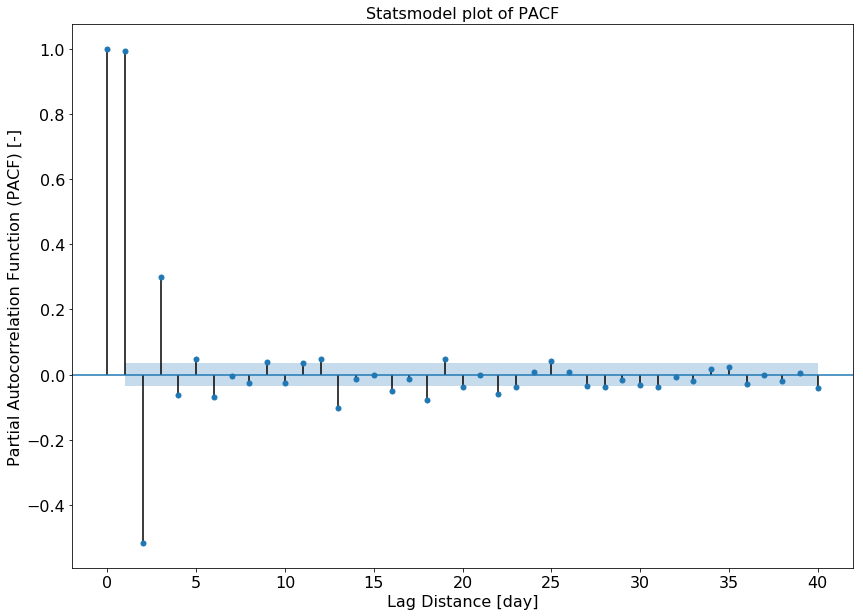

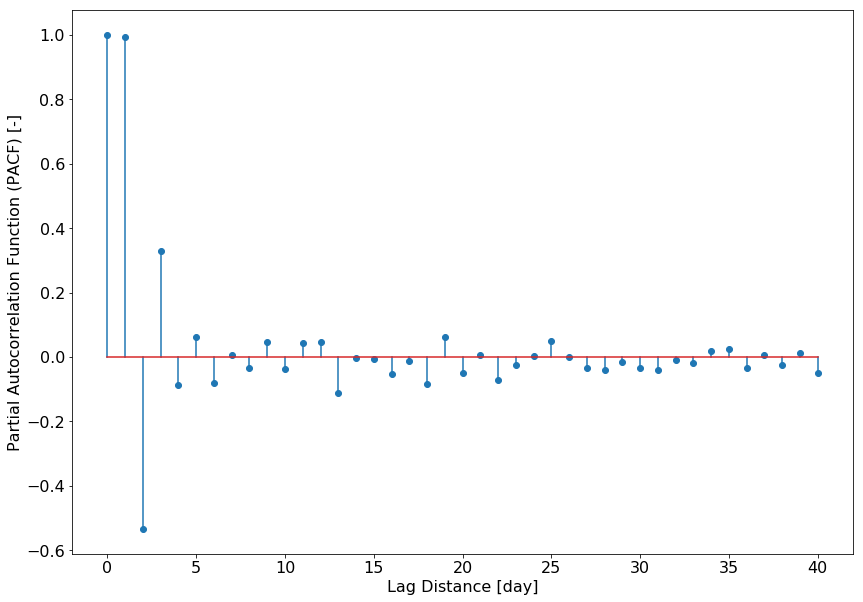

In [17]:
Qt = pd.Series(df_train['Q'].values,df_train['SerDates'].values)  # make a matrix of Q and Serial Dates

Qpacf = sm.pacf(Qt)                                               # partial autocorrelation function

plt.figure(figsize=(14,10))
plt.stem(Qpacf)                                                   # plot using a stem plot
plt.ylabel('Partial Autocorrelation Function (PACF) [-]',fontsize=16)
plt.xlabel('Lag Distance [day]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

from statsmodels.graphics.tsaplots import plot_pacf
f, axarr = plt.subplots(1, 1, figsize=(14,10))
_ = plot_pacf(Qt,method='ols',lags=40,ax=axarr.axes)
axarr.set_title('Statsmodel plot of PACF',fontsize=16)
axarr.set_ylabel('Partial Autocorrelation Function (PACF) [-]',fontsize=16)
axarr.set_xlabel('Lag Distance [day]',fontsize=16)
axarr = plt.gca()
axarr.tick_params('both',labelsize=16)